In [3]:
import os

import cv2 as cv
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader
from my_models import *
from cat_dog_dataset import my_Dataset
global PATH, IMG_SIZE, BATCH_SIZE, DEVICE


In [2]:

def train(epoch, model, train_dataloader, criterion, optimizer):
    '''模型训练函数'''
    global print_loss
    # 调整为训练模式
    model.train()
    losses = []
    plot_loss = 0
    total_num = len(train_dataloader.dataset)
    print_thre = total_num//(BATCH_SIZE*5)
    for i, (img, label) in enumerate(train_dataloader):
        img, label = img.to(DEVICE), label.to(DEVICE)
        out = model(img)
        # 计算损失
        loss = criterion(out, label.squeeze())
        losses.append(loss.item())
        # 误差反向传播
        loss.backward()
        # 优化采用设定的优化方法对网络中的各个参数进行调整
        optimizer.step()
        # 清除优化器中的梯度以便下一次计算
        optimizer.zero_grad()
        if (i+1) % print_thre == 0:
            plot_loss += np.mean(losses)
            print('TRAINING: Epoch:{} [{} / {} ({:.2f}%)] Loss:{}'.format(
                epoch, (i+1)*BATCH_SIZE, total_num, (i+1)*BATCH_SIZE/total_num*100, plot_loss))
            losses.clear()
    print_loss.append(plot_loss/5)


def test(model, test_dataloader, criterion):
    '''模型验证函数'''
    model.eval()
    cnt = 0
    losses = []
    total_num = len(test_dataloader.dataset)
    for i, (img, label) in enumerate(test_dataloader):
        img, label = img.to(DEVICE), label.to(DEVICE)
        out = model(img)
        # 计算损失
        loss = criterion(out, label.squeeze())
        losses.append(loss.item())
        y = out.argmax(1, keepdim=True)
        num = (y-label).abs().sum()
        cnt += num
    acc = 1-cnt/total_num
    print('\nTESTING: Loss:{},Accuracy:[{} / {} ({:.6f}%)]\n'.format(np.mean(losses), total_num-cnt, total_num,
          acc*100))
    return acc.item()


In [3]:
global PATH, IMG_SIZE, BATCH_SIZE, DEVICE
'''定义相关超参数'''
# 训练集路径
PATH = "data/train"
# 裁剪图像大小
IMG_SIZE = 256
BATCH_SIZE = 25
EPOCHS = 5
DEVICE = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
WORKERS = 0
# 训练数据比例
TRAIN_RATE = 0.7

print("using device {}".format(DEVICE))


using device cuda


In [4]:

# 数据集分割，采用固定的seed
img_data = my_Dataset("train", PATH, IMG_SIZE)
IMG_NUM = len(img_data)
TRAIN_NUM = int(IMG_NUM*TRAIN_RATE)
train_data, vali_data = data.random_split(
    img_data, [TRAIN_NUM, IMG_NUM-TRAIN_NUM], torch.Generator().manual_seed(1))
train_dataloader = DataLoader(train_data, BATCH_SIZE,
                                shuffle=True, num_workers=WORKERS, drop_last=True)
vali_dataloader = DataLoader(vali_data, BATCH_SIZE,
                                shuffle=True, num_workers=WORKERS, drop_last=True)


In [5]:

# 定义网络模型
model = get_resnet18_model(False, True).to(DEVICE)
# model = get_vgg16_model(True, False).to(DEVICE)
print("using model:", model._get_name())
# 实例化一个优化器，优化方式为adam方法
optimizer = optim.Adam(model.parameters())
# 定义损失函数为交叉熵函数
criterion = nn.CrossEntropyLoss()


using model: ResNet


In [6]:
print_loss = []
accs = []
for epoch in range(EPOCHS):
    train(epoch, model, train_dataloader, criterion, optimizer)
    if (epoch+1) % 1 == 0:
        acc = test(model, vali_dataloader, criterion)
        accs.append(acc)


TRAINING: Epoch:0 [3500 / 17500 (20.00%)] Loss:0.4355498826929501
TRAINING: Epoch:0 [7000 / 17500 (40.00%)] Loss:0.8015327609011105
TRAINING: Epoch:0 [10500 / 17500 (60.00%)] Loss:1.1669573251690184
TRAINING: Epoch:0 [14000 / 17500 (80.00%)] Loss:1.5157123669981958
TRAINING: Epoch:0 [17500 / 17500 (100.00%)] Loss:1.869678144156933

TESTING: Loss:0.33703973988691965,Accuracy:[7368 / 7500 (98.239998%)]

TRAINING: Epoch:1 [3500 / 17500 (20.00%)] Loss:0.349032447380679
TRAINING: Epoch:1 [7000 / 17500 (40.00%)] Loss:0.7017754286527633
TRAINING: Epoch:1 [10500 / 17500 (60.00%)] Loss:1.0519416672842843
TRAINING: Epoch:1 [14000 / 17500 (80.00%)] Loss:1.3934980824589729
TRAINING: Epoch:1 [17500 / 17500 (100.00%)] Loss:1.7358062084232058

TESTING: Loss:0.3362422350049019,Accuracy:[7339 / 7500 (97.853333%)]

TRAINING: Epoch:2 [3500 / 17500 (20.00%)] Loss:0.3454380876251629
TRAINING: Epoch:2 [7000 / 17500 (40.00%)] Loss:0.6887983124170984
TRAINING: Epoch:2 [10500 / 17500 (60.00%)] Loss:1.030072318

In [12]:
if acc >= 0.97:
    torch.save(model.state_dict(), "resnet18_state.pth")
    print("模型参数保存成功")


模型参数保存成功


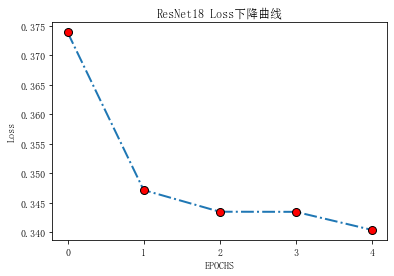

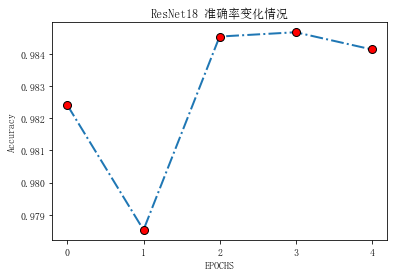

In [11]:
plt.figure(1)
plt.plot(range(EPOCHS), print_loss,   linestyle='-.', linewidth=2,
         marker='o', markersize=8, markeredgecolor='k', markerfacecolor='red')
plt.xlabel("EPOCHS")
plt.ylabel("Loss")
plt.xticks(range(EPOCHS))
plt.title("ResNet18 Loss下降曲线")
plt.savefig("Loss_resnet.jpg")

plt.figure(2)
plt.plot(range(EPOCHS), accs,linestyle='-.', linewidth=2,
         marker='o', markersize=8, markeredgecolor='k', markerfacecolor='red')
plt.xlabel("EPOCHS")
plt.ylabel("Accuracy")
plt.xticks(range(EPOCHS))
plt.title("ResNet18 准确率变化情况")
plt.savefig("Accuracy_resnet.jpg")

